In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
Image_width = 240
Image_hight = 320
CHANNELS=3
EPOCHS=50


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plants",
    shuffle = True,
    image_size = (Image_width,Image_hight),
    batch_size=BATCH_SIZE
    
)

Found 4000 files belonging to 8 classes.


In [5]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [6]:
len(dataset)


125

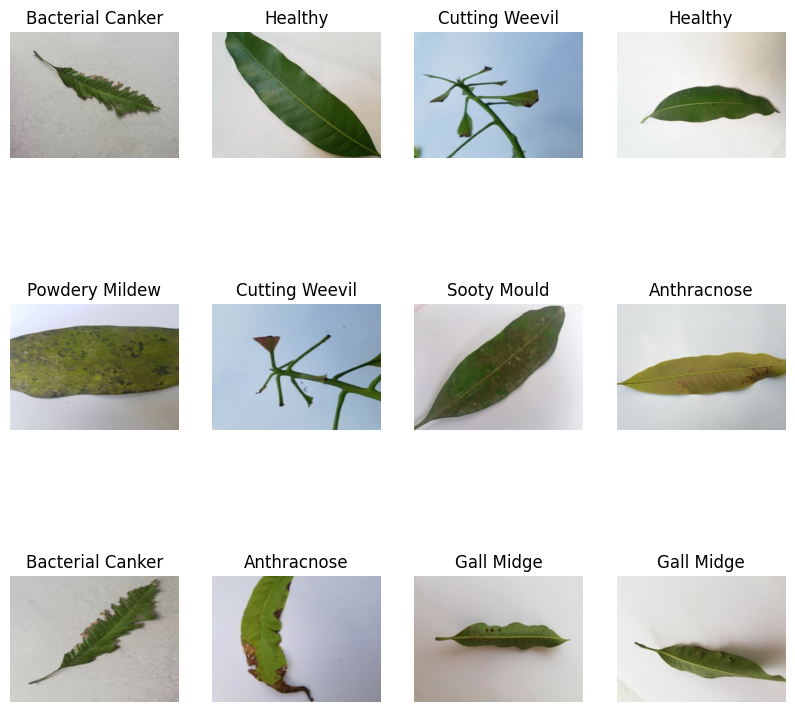

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
 train_size = 0.8
len(dataset)*train_size

100.0

In [9]:
train_ds = dataset.take(100)
len(train_ds)

100

In [10]:
test_ds = dataset.skip(100)
len(test_ds)

25

In [11]:
val_size = 0.1
len(dataset) * val_size

12.5

In [12]:
val_ds = test_ds.take(12)
len(val_ds)

12

In [13]:
test_ds = test_ds.skip(12)
len(test_ds)

13

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
# def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
#     """
#     Splits a TensorFlow dataset into training, validation, and test sets.

#     Args:
#         ds (tf.data.Dataset): The input TensorFlow dataset to be split.
#         train_split (float): Fraction of the dataset to use for training. Default is 0.8 (80%).
#         val_split (float): Fraction of the dataset to use for validation. Default is 0.1 (10%).
#         test_split (float): Fraction of the dataset to use for testing. Default is 0.1 (10%).
#         shuffle (bool): Whether to shuffle the dataset before splitting. Default is True.
#         shuffle_size (int): The buffer size for shuffling. Default is 10,000.

#     Returns:
#         tuple: Three TensorFlow datasets (train_ds, val_ds, test_ds) corresponding to the training, validation, and test splits.

#     Raises:
#         AssertionError: If the sum of `train_split`, `val_split`, and `test_split` is not 1.
#     """
#     # Ensure the sum of the splits equals 1
#     assert (train_split + test_split + val_split) == 1, "The splits must sum up to 1."

#     # Get the total size of the dataset
#     ds_size = len(ds)  # Assuming `ds` has a length attribute (e.g., `tf.data.Dataset` object)
#     print(f"Total dataset size: {ds_size} samples")

#     # Shuffle the dataset if specified
#     if shuffle:
#         print(f"Shuffling the dataset with a buffer size of {shuffle_size}...")
#         ds = ds.shuffle(shuffle_size, seed=12)  # Shuffle with a fixed seed for reproducibility

#     # Calculate the number of samples for each split
#     train_size = int(train_split * ds_size)  # Number of training samples
#     val_size = int(val_split * ds_size)      # Number of validation samples
#     print(f"Training size: {train_size} samples")
#     print(f"Validation size: {val_size} samples")
#     print(f"Test size: {ds_size - train_size - val_size} samples")  # Remaining samples for testing

#     # Split the dataset into training, validation, and test sets
#     train_ds = ds.take(train_size)  # Take the first `train_size` samples for training
#     val_ds = ds.skip(train_size).take(val_size)  # Skip training samples, take the next `val_size` samples for validation
#     test_ds = ds.skip(train_size).skip(val_size)  # Skip training and validation samples, take the rest for testing

# #     Return the three datasets
#     return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

100

In [18]:
len(val_ds)

12

In [19]:
len(test_ds)


13

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
 resize_and_rescale = tf.keras.Sequential([
 layers.Resizing(Image_width, Image_hight),  # Resize images to the specified width and height
 layers.Rescaling(1./255),  # Rescale pixel values to the range [0, 1]
 ])

In [22]:
data_augmentation = tf.keras.Sequential([
 layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
 layers.RandomRotation(0.2),  # Randomly rotate images by up to 20% (of 360 degrees)
 ])


In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
 input_shape = (Image_width, Image_hight, CHANNELS)
 n_classes = len(class_names)
 model = models.Sequential([
 layers.Input(shape=input_shape),  # Specify input shape using Input layer
 resize_and_rescale,  # Assuming this is a preprocessing layer
 layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Conv2D(64, (3, 3), activation='relu'),
 layers.MaxPooling2D((2, 2)),
 layers.Flatten(),
 layers.Dense(128, activation='relu'),
 layers.Dropout(0.2),
 layers.Dense(64, activation='relu'),
 layers.Dropout(0.2),
 layers.Dense(n_classes, activation='softmax'),
 ])
 model.build()

In [25]:

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 240, 320, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 238, 318, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 119, 159, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 117, 157, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 58, 78, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 76, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 36, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,584 (783.53 KB)

 Trainable params: 200,584 (783.53 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.1974 - loss: 1.9369 - val_accuracy: 0.4245 - val_loss: 1.5636
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.3145 - loss: 1.6111 - val_accuracy: 0.4245 - val_loss: 1.3408
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3568 - loss: 1.5263 - val_accuracy: 0.4297 - val_loss: 1.2939
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.4201 - loss: 1.4157 - val_accuracy: 0.5807 - val_loss: 1.0406
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.5232 - loss: 1.1248 - val_accuracy: 0.4714 - val_loss: 1.1903
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.5760 - loss: 1.0270 - val_accuracy: 0.6927 - val_loss: 0.6981
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7041 - loss: 0.8071 - val_accuracy: 0.8776 - val_loss: 0.3980
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.7744 - loss: 0.6176 - val_accu

In [28]:
scores = model.evaluate(test_ds)

13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 469ms/step - accuracy: 0.9810 - loss: 0.0556


In [29]:
history


In [30]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 100}

In [31]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
type(history.history['loss'])


list

In [33]:
len(history.history['loss'])


50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.7788876295089722,
 1.564305305480957,
 1.4978398084640503,
 1.3594893217086792,
 1.103289008140564]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

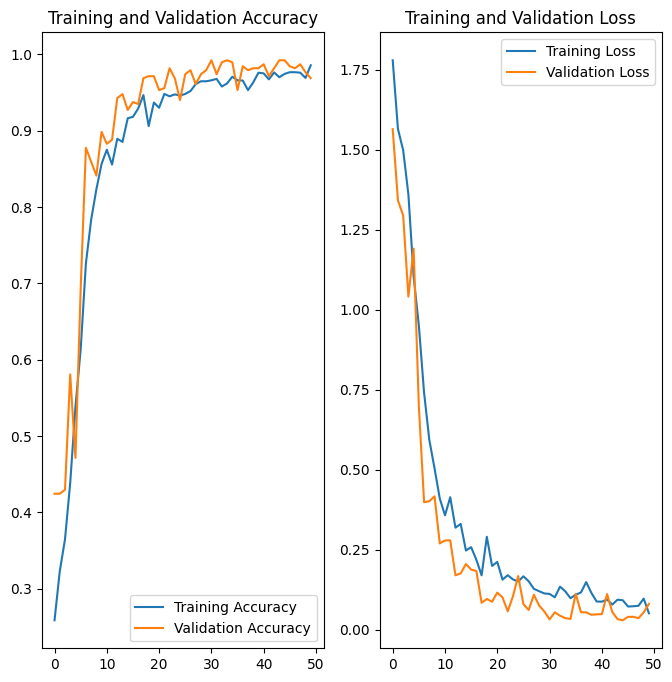

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
predicted label: Healthy


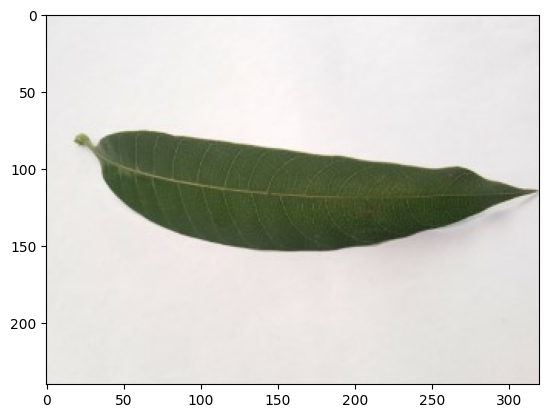

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


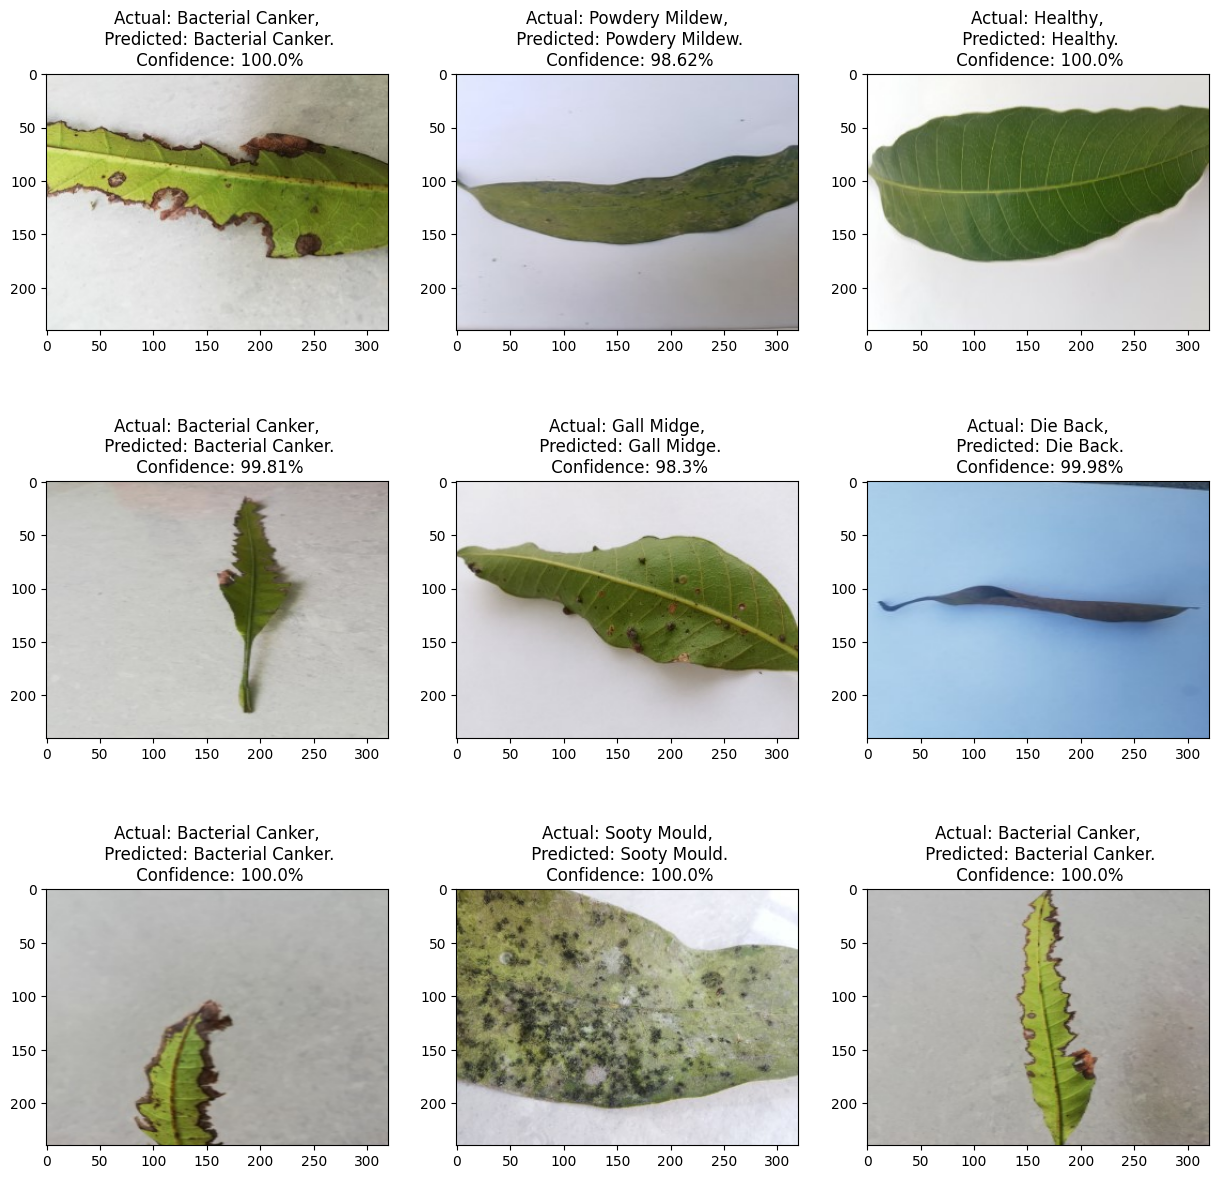

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
#         plt.axis("off")

In [44]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model_version=1
model.save(f"../models/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `tf.saved_model.save()` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/models/1.

In [45]:
model.save(f"../models/{model_version}.keras")


In [54]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model_version = 1
model.save(f"/models/{model_version}")

ValueError: invalid literal for int() with base 10: '1.h5'